In [ ]:
"""
3/15/2021

Goal:

Narrow down to Logistic regressiong and Random forest
1. Hyperparameter tuning
2. Feature importance

Find out why those frames are selected??


"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [2]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')

In [3]:
len(bad),len(good)

(808, 1024)

In [4]:
test = pd.concat([bad,good],axis=0).reset_index(drop=True)
# test

In [5]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

In [6]:
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 0)
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 0)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 0)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

In [7]:
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

In [8]:
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 0)

In [9]:
# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
test['label'] = label_list
test.iloc[:,:]

filename     lp_cat  \
0                                   IMG_0185.MOV_12.jpg   5.052993   
1                                  IMG_0185.MOV_156.jpg  12.748102   
2                                  IMG_0185.MOV_162.jpg  34.031338   
3                                  IMG_0185.MOV_168.jpg  35.830179   
4                                  IMG_0185.MOV_174.jpg  33.939300   
...                                                 ...        ...   
1827  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  21.401767   
1828  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  20.284242   
1829  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  21.238435   
1830  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  20.905433   
1831  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  22.206291   

          lp_all  lp_ratio  lp_cat_canny  lp_all_canny  lp_ratio_canny  blur  \
0     151.810569  0.033285  13687.793353  20847.260510        0.656575     0   
1      61.145684  0.208487  10715.795177   6489.486205        1.651255     0   
2      53.224166  0.639396   5607.710122   2606.958020        2.151055     0   
3      78.479448  0.456555   7468.365741  11896.382691        0.627785     0   
4     125.446714  0.270548   7138.382092  26640.493901        0.267952     0   
...          ...       ...           ...           ...             ...   ...   
1827  126.141180  0.169665  14373.143661   4680.821614        3.070645     0   
1828  133.398163  0.152058  12532.716580   4792.583325        2.615023     0   
1829  129.968949  0.163412  13780.555614   5021.751296        2.744173     0   
1830  124.860466  0.167430  14052.346956   4535.443542        3.098340     0   
1831  123.752467  0.179441  15593.095441   5893.015827        2.646030     0   

          to_ctr     cat_x  ...  eye_ratio  ear_w1  ear_w2  ear_w ear_h1  \
0     189.620674  0.638889  ...   0.000000       0       0    0.0      0   
1     383.255789  0.224074  ...   0.064794       0       0    0.0      0   
2     381.430203  0.291667  ...   0.061065       0       0    0.0      0   
3     585.511742  0.120370  ...   0.062416     163       0  163.0    189   
4     509.231774  0.105556  ...   0.069389       0       0    0.0      0   
...          ...       ...  ...        ...     ...     ...    ...    ...   
1827  251.872984  0.438889  ...   0.049674     112       0  112.0     94   
1828  266.443240  0.450000  ...   0.049905       0       0    0.0      0   
1829  256.007812  0.497222  ...   0.049919     116       0  116.0     92   
1830  271.812435  0.470833  ...   0.047719       0       0    0.0      0   
1831  261.262320  0.434722  ...   0.051212      92       0   92.0     78   

     ear_h2  ear_h  nose_x  nose_y  label  
0         0    0.0       0       0    bad  
1         0    0.0       0       0    bad  
2         0    0.0       0       0    bad  
3         0  189.0     288     789    bad  
4         0    0.0       0       0    bad  
...     ...    ...     ...     ...    ...  
1827      0   94.0     399     231   good  
1828      0    0.0     417     225   good  
1829      0   92.0     444     218   good  
1830      0    0.0     432     207   good  
1831      0   78.0       0       0   good  

[1832 rows x 40 columns]

### A. Conventional train test split

In [10]:
# df = test.copy()
# # Train test split
# X = df.iloc[:,:-1]

# mapping = {'bad':0, 'good':1}
# y = df['label'].map(mapping)

# X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

### B. Proper train test split

In [11]:
# Make sure all the frames in test set are from videos not seen in training set
# Test set size: ~367 frames
df = test.copy()
df.head(370)

filename     lp_cat      lp_all  lp_ratio  lp_cat_canny  \
0     IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285  13687.793353   
1    IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487  10715.795177   
2    IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   5607.710122   
3    IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   7468.365741   
4    IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   7138.382092   
..                    ...        ...         ...       ...           ...   
365  IMG_8976.MOV_738.jpg   0.962615  151.081632  0.006371  48631.284899   
366  IMG_8976.MOV_741.jpg   1.034143  237.888215  0.004347  67798.116109   
367  IMG_8976.MOV_744.jpg   0.693148  467.889270  0.001481  44918.992695   
368  IMG_8976.MOV_747.jpg   1.013045  366.593430  0.002763  65764.920556   
369  IMG_8976.MOV_750.jpg   1.001304  441.297709  0.002269  65875.934997   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  ...  eye_ratio  \
0    20847.260510        0.656575     0  189.620674  0.638889  ...   0.000000   
1     6489.486205        1.651255     0  383.255789  0.224074  ...   0.064794   
2     2606.958020        2.151055     0  381.430203  0.291667  ...   0.061065   
3    11896.382691        0.627785     0  585.511742  0.120370  ...   0.062416   
4    26640.493901        0.267952     0  509.231774  0.105556  ...   0.069389   
..            ...             ...   ...         ...       ...  ...        ...   
365  27927.698068        1.741328     1  499.609848  0.713889  ...   0.000000   
366  50547.843436        1.341266     1  491.382743  0.718519  ...   0.000000   
367  76978.831429        0.583524     1  400.249922  0.650000  ...   0.000000   
368  70977.628517        0.926558     1  475.063154  0.715741  ...   0.000000   
369  78993.051003        0.833946     1  468.363107  0.712963  ...   0.000000   

     ear_w1  ear_w2  ear_w ear_h1 ear_h2  ear_h  nose_x  nose_y  label  
0         0       0    0.0      0      0    0.0       0       0    bad  
1         0       0    0.0      0      0    0.0       0       0    bad  
2         0       0    0.0      0      0    0.0       0       0    bad  
3       163       0  163.0    189      0  189.0     288     789    bad  
4         0       0    0.0      0      0    0.0       0       0    bad  
..      ...     ...    ...    ...    ...    ...     ...     ...    ...  
365       0       0    0.0      0      0    0.0       0       0    bad  
366       0       0    0.0      0      0    0.0       0       0    bad  
367       0       0    0.0      0      0    0.0       0       0    bad  
368       0       0    0.0      0      0    0.0       0       0    bad  
369       0       0    0.0      0      0    0.0       0       0    bad  

[370 rows x 40 columns]

In [12]:
df['video'] = df['filename'].apply(lambda x: x.split('.M')[0])

In [13]:
# Use frames from 12 videos as test set
test_video = df.groupby('video').count().iloc[10:22,:].index.tolist()
len(test_video)

12

In [14]:
# Separate features and target
X = df.iloc[:,:-2]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)


# Manual tran test split
X_train_df = df[~df.video.isin(test_video)].iloc[:,:-2]
X_test_df = df[df.video.isin(test_video)].iloc[:,:-2]

y_train = df[~df.video.isin(test_video)]['label'].map(mapping)
y_test = df[df.video.isin(test_video)]['label'].map(mapping)

In [15]:
len(X_train_df),len(X_test_df)

(1704, 128)

### Reset train_df and test_df index

In [16]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [17]:
X_test_df

filename     lp_cat      lp_all  lp_ratio  lp_cat_canny  \
0    IMG_0253.MOV_144.jpg   2.386208   51.840806  0.046030  15310.361060   
1    IMG_0253.MOV_162.jpg   1.654996   39.046600  0.042385  13118.477750   
2    IMG_0253.MOV_168.jpg   1.448652   46.981061  0.030835  20798.123650   
3    IMG_0253.MOV_174.jpg   1.641137   76.725604  0.021390  34971.160718   
4    IMG_0257.MOV_120.jpg  38.872382  109.691005  0.354381  19225.445776   
..                    ...        ...         ...       ...           ...   
123  IMG_3554.MOV_363.jpg   6.893756   51.391806  0.134141  22734.425657   
124  IMG_3554.MOV_396.jpg  17.863301   56.146853  0.318153  27843.528360   
125  IMG_3554.MOV_399.jpg   6.688418   51.959772  0.128723  26900.606564   
126  IMG_3554.MOV_402.jpg   6.650422   52.345171  0.127049  25497.761660   
127   IMG_3555.MOV_57.jpg  32.822912   65.508827  0.501046   5961.773084   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  ...  \
0     2186.095590        7.003519     0  234.931905  0.397396  ...   
1      633.441839       20.709838     0  205.572372  0.398958  ...   
2     5401.785044        3.850232     0  124.326184  0.438021  ...   
3    16892.263211        2.070247     1   61.554854  0.476562  ...   
4     9973.604492        1.927633     0  750.345254  0.104630  ...   
..            ...             ...   ...         ...       ...  ...   
123   2815.084526        8.075930     0  529.060488  0.010185  ...   
124   3864.591037        7.204780     0  386.959946  0.154630  ...   
125   3360.847981        8.004113     0  364.967122  0.175000  ...   
126   3533.131619        7.216760     0  358.711583  0.182407  ...   
127   1702.641493        3.501485     0  661.420441  0.054630  ...   

       eye_size  eye_ratio  ear_w1 ear_w2  ear_w ear_h1  ear_h2  ear_h  \
0     4736.0000   0.070059     121      0  121.0    137       0  137.0   
1        0.0000   0.000000       0      0    0.0      0       0    0.0   
2        0.0000   0.000000       0      0    0.0      0       0    0.0   
3     1479.0000   0.051176       0      0    0.0      0       0    0.0   
4    10809.7500   0.051759     202    199  200.5    196     208  202.0   
..          ...        ...     ...    ...    ...    ...     ...    ...   
123   7827.1875   0.114901     164      0  164.0    169       0  169.0   
124   4416.0000   0.055926     116      0  116.0    173       0  173.0   
125   4265.2500   0.060737     126      0  126.0    153       0  153.0   
126   3517.5000   0.050089     124    102  113.0    151     112  131.5   
127   9750.0000   0.056070     111      0  111.0    123       0  123.0   

     nose_x  nose_y  
0       873     831  
1       869     606  
2       916     617  
3       989     690  
4       325     632  
..      ...     ...  
123     102    1095  
124     260    1026  
125     277    1019  
126       0       0  
127     226     737  

[128 rows x 39 columns]

In [18]:
X_test_df.columns

Index(['filename', 'lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny',
       'lp_all_canny', 'lp_ratio_canny', 'blur', 'to_ctr', 'cat_x', 'cat_y',
       'face_size', 'size_ratio', 'eyes', 'ears', 'nose', 'num_eye', 'num_ear',
       'num_nose', 'eye_x1', 'eye_y1', 'eye_w1', 'eye_x2', 'eye_y2', 'eye_w2',
       'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio', 'ear_w1',
       'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h', 'nose_x', 'nose_y'],
      dtype='object')

In [19]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        128 non-null    object 
 1   lp_cat          128 non-null    float64
 2   lp_all          128 non-null    float64
 3   lp_ratio        128 non-null    float64
 4   lp_cat_canny    128 non-null    float64
 5   lp_all_canny    128 non-null    float64
 6   lp_ratio_canny  128 non-null    float64
 7   blur            128 non-null    int64  
 8   to_ctr          128 non-null    float64
 9   cat_x           128 non-null    float64
 10  cat_y           128 non-null    float64
 11  face_size       128 non-null    int64  
 12  size_ratio      128 non-null    float64
 13  eyes            128 non-null    object 
 14  ears            128 non-null    object 
 15  nose            128 non-null    object 
 16  num_eye         128 non-null    int64  
 17  num_ear         128 non-null    int

In [20]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
123    1
124    1
125    1
126    1
127    1
Name: label, Length: 128, dtype: int64

## Scale continuous variables

In [21]:
headers = ['filename','lp_cat','lp_all','lp_ratio','lp_cat_canny','lp_all_canny','lp_ratio_canny','blur',\
               'to_ctr','cat_x','cat_y','face_size','size_ratio',\
               'eyes','ears','nose']

In [22]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny',\
#             'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
#             'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
#             'nose_x'
           ]
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [23]:
# Try without 'blur'
X_train = X_train_con_df

In [24]:
# # Combine Con and Cat
# X_train = pd.concat([X_train_con_df,X_train_df[['blur']]], axis='columns')
# X_train

In [25]:
# Repeat for test set
# Continuous variables
# features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_con_df,X_test_df[['blur']]], axis='columns')
X_test

lp_cat    lp_all  lp_ratio  lp_cat_canny  lp_all_canny  lp_ratio_canny  \
0   -0.602344 -1.052058 -0.624786     -0.431543     -0.763044        1.040416   
1   -0.611053 -1.326168 -0.629732     -0.560931     -0.881224        5.262947   
2   -0.613511 -1.156176 -0.645408     -0.107599     -0.518284        0.068977   
3   -0.611219 -0.518914 -0.658226      0.729041      0.356309       -0.479387   
4   -0.167762  0.187354 -0.206309     -0.200434     -0.170302       -0.523322   
..        ...       ...       ...           ...           ...             ...   
123 -0.548655 -1.061678 -0.505206      0.006702     -0.715169        1.370795   
124 -0.417998 -0.959803 -0.255475      0.308294     -0.635287        1.102419   
125 -0.551101 -1.049509 -0.512559      0.252633     -0.673629        1.348671   
126 -0.551554 -1.041252 -0.514831      0.169823     -0.660515        1.106109   
127 -0.239816 -0.759227 -0.007264     -0.983394     -0.799842       -0.038463   

     size_ratio    to_ctr  face_size  size_ratio  ...     eye_h  eye_size  \
0     -0.572942 -1.547337  -0.572942   -0.572942  ... -0.099306 -0.455752   
1     -0.713426 -1.691575  -0.713426   -0.713426  ... -1.721069 -0.942517   
2     -0.803892 -2.090724  -0.803892   -0.803892  ... -1.721069 -0.942517   
3     -0.843750 -2.399108  -0.843750   -0.843750  ... -0.603367 -0.790506   
4      0.415467  0.984800   0.415467    0.415467  ...  0.503377  0.168507   
..          ...       ...        ...         ...  ...       ...       ...   
123   -0.569296 -0.102334  -0.569296   -0.569296  ...  0.169162 -0.138041   
124   -0.493442 -0.800449  -0.493442   -0.493442  ... -0.318463 -0.488642   
125   -0.554573 -0.908496  -0.554573   -0.554573  ... -0.395168 -0.504136   
126   -0.554573 -0.939228  -0.554573   -0.554573  ... -0.570494 -0.580989   
127    0.170829  0.547928   0.170829    0.170829  ...  0.415714  0.059586   

     eye_ratio    ear_w1    ear_w2     ear_w    ear_h1    ear_h2     ear_h  \
0    -0.158669 -0.207314 -0.752085 -0.192305 -0.138598 -0.737439 -0.098396   
1    -0.327732 -1.395206 -0.752085 -1.442164 -1.325340 -0.737439 -1.365726   
2    -0.327732 -1.395206 -0.752085 -1.442164 -1.325340 -0.737439 -1.365726   
3    -0.204236 -1.395206 -0.752085 -1.442164 -1.325340 -0.737439 -1.365726   
4    -0.202831  0.587887  1.243654  0.628884  0.372481  1.254604  0.502892   
..         ...       ...       ...       ...       ...       ...       ...   
123  -0.050459  0.214830 -0.752085  0.251860  0.138598 -0.737439  0.197623   
124  -0.192774 -0.256400 -0.752085 -0.243952  0.173247 -0.737439  0.234625   
125  -0.181165 -0.158227 -0.752085 -0.140658  0.000000 -0.737439  0.049613   
126  -0.206860 -0.177862  0.270857 -0.274940 -0.017325  0.335200 -0.149274   
127  -0.192426 -0.305486 -0.752085 -0.295599 -0.259871 -0.737439 -0.227904   

     blur  
0       0  
1       0  
2       0  
3       1  
4       0  
..    ...  
123     0  
124     0  
125     0  
126     0  
127     0  

[128 rows x 28 columns]

In [26]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

### A. Basic

In [27]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  0.2558


Feature                    Coef
21          ear_w1    [2.2079646156461035]
3     lp_cat_canny    [1.9532294606083298]
13          eye_w1     [1.870047100892719]
17          eye_h2    [1.3546094483045115]
6       size_ratio    [1.1687902048845344]
9       size_ratio    [1.1687902048845344]
0           lp_cat    [1.0496017337566146]
10         num_eye    [0.7839019779009082]
22          ear_w2     [0.537937040411764]
16          eye_h1   [0.19157760401235074]
4     lp_all_canny   [0.17552668354997913]
12        num_nose  [0.047125761008144654]
20       eye_ratio  [0.022761934194867436]
25          ear_h2   [-0.0688009758849908]
11         num_ear  [-0.24158846216336816]
15           eye_w  [-0.27347013811296556]
5   lp_ratio_canny   [-0.3123883705971279]
14          eye_w2  [-0.33959702112174933]
18           eye_h  [-0.37429852696856686]
26           ear_h  [-0.44808543595610456]
24          ear_h1    [-0.450064298648651]
7           to_ctr   [-0.6343718419565234]
8        face_size   [-0.7883197191439865]
1           lp_all   [-1.1671286746805636]
23           ear_w   [-1.1677877178707197]
2         lp_ratio   [-1.1702355453418778]
19        eye_size   [-2.8442427945063105]

In [28]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)                45                41
Good (1)                6                36

In [29]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [30]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [31]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6328125 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.52      0.66        86
           1       0.47      0.86      0.61        42

    accuracy                           0.63       128
   macro avg       0.67      0.69      0.63       128
weighted avg       0.75      0.63      0.64       128



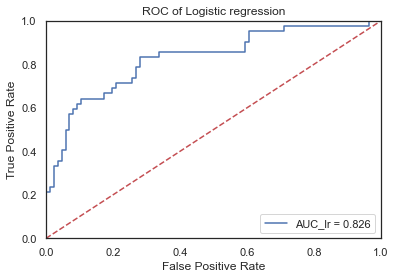

In [32]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Logistic regression')
plt.show()

### B. Hyperparameter Tuning

In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
# note that train and validation sets are not split properly!

In [35]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.812001 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [36]:
# Use best model on test set
lm_best = grid_result.estimator
lm_best.fit(X_train,y_train)
y_predict = lm_best.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)                46                40
Good (1)                6                36

In [37]:
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm_best.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False).head(5)

intercept:  0.2558


Feature                  Coef
3   lp_cat_canny  [1.8052123643352638]
21        ear_w1  [1.5537003568844936]
13        eye_w1  [1.4209149789026971]
17        eye_h2  [1.1993378758095792]
9     size_ratio  [1.0202869862733994]

In [38]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.640625 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.53      0.67        86
           1       0.47      0.86      0.61        42

    accuracy                           0.64       128
   macro avg       0.68      0.70      0.64       128
weighted avg       0.75      0.64      0.65       128



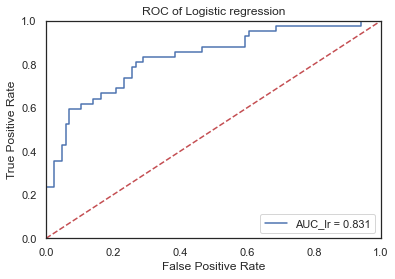

In [39]:
# Logistic regression ROC curve
y_scores = lm_best.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Logistic regression')
plt.show()

In [40]:
# Only small improvement compared to the basic model!

## 2. Random Forests

### A. Basic

In [41]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [42]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=200)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.80625

In [43]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.796875 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.86      0.84      0.85        86
           1       0.68      0.71      0.70        42

    accuracy                           0.80       128
   macro avg       0.77      0.78      0.77       128
weighted avg       0.80      0.80      0.80       128



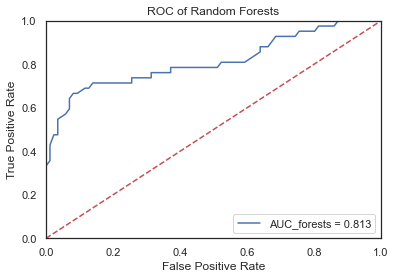

In [44]:
# Random Forests ROC curve
y_scores = randomforest.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Random Forests')
plt.show()

In [45]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [46]:
# y_scores

### B. Hyperparameter Tuning
The most important parameter is the number of random features to sample at each split point (max_features).  Another important parameter for random forest is the number of trees (n_estimators). Ideally, this should be increased until no further improvement is seen in the model.

In [47]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [48]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.909612 using {'max_features': 'log2', 'n_estimators': 100}


In [49]:
# Use best model on test set
rf_best = grid_result.estimator
rf_best.fit(X_train,y_train)
y_predict = rf_best.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)                75                11
Good (1)               12                30

In [50]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.8203125 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.86      0.87      0.87        86
           1       0.73      0.71      0.72        42

    accuracy                           0.82       128
   macro avg       0.80      0.79      0.79       128
weighted avg       0.82      0.82      0.82       128



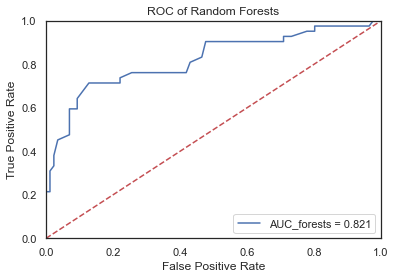

In [51]:
# Random Forests ROC curve
y_scores = rf_best.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Random Forests')
plt.show()

In [52]:
# Not necessarily better

### C. Feature importatnce

In [53]:
pd.DataFrame(list(zip(X_train.columns,np.transpose(rf_best.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

Feature      Coef
1           lp_all  0.090036
3     lp_cat_canny  0.084014
5   lp_ratio_canny  0.066634
17          eye_h2  0.066604
4     lp_all_canny  0.060562
20       eye_ratio  0.048690
16          eye_h1  0.048563
14          eye_w2  0.047168
7           to_ctr  0.043418
10         num_eye  0.041273
2         lp_ratio  0.038906
9       size_ratio  0.036892
0           lp_cat  0.036238
6       size_ratio  0.035737
8        face_size  0.032370
19        eye_size  0.030820
15           eye_w  0.027848
26           ear_h  0.025904
21          ear_w1  0.025413
13          eye_w1  0.024962
18           eye_h  0.020861
23           ear_w  0.019032
24          ear_h1  0.015964
22          ear_w2  0.011380
25          ear_h2  0.010559
11         num_ear  0.006308
12        num_nose  0.003844

In [54]:
# Logistic regression has higher AUC score
# But Random forest has better precision

## Examine model results

### 1. Check the best frame for each video file

In [55]:
test_df = df[df.video.isin(test_video)].reset_index(drop=True)
# [['video','filename','label']]

model = randomforest
# model = rf_best
threshold = 0.56
y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
test_df['label'] = y_test
test_df['pred'] = [0 if x==False else 1 for x in y_predict]
test_df['prob'] = model.predict_proba(X_test)[:, 1]

In [56]:
# test_df

In [57]:
test_df['prob_max'] = test_df.groupby(['video'])['prob'].transform(max)

In [58]:
pd.set_option('display.max_columns', None)
test_df[test_df.video=="IMG_0253"].drop(columns=['eyes','ears','nose','video']).sort_values('prob',ascending=False)

filename    lp_cat     lp_all  lp_ratio  lp_cat_canny  \
3   IMG_0253.MOV_174.jpg  1.641137  76.725604  0.021390  34971.160718   
0   IMG_0253.MOV_144.jpg  2.386208  51.840806  0.046030  15310.361060   
86  IMG_0253.MOV_150.jpg  2.472868  53.984868  0.045807  28690.978944   
87  IMG_0253.MOV_156.jpg  2.414697  52.078203  0.046367  19410.692181   
2   IMG_0253.MOV_168.jpg  1.448652  46.981061  0.030835  20798.123650   
88  IMG_0253.MOV_180.jpg  1.586603  39.709572  0.039955  30942.399234   
1   IMG_0253.MOV_162.jpg  1.654996  39.046600  0.042385  13118.477750   

    lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x     cat_y  \
3   16892.263211        2.070247     1   61.554854  0.476562  0.538889   
0    2186.095590        7.003519     0  234.931905  0.397396  0.618519   
86   4049.574865        7.084936     0  216.085631  0.392188  0.557407   
87   1944.290148        9.983434     0  211.021326  0.390104  0.502778   
2    5401.785044        3.850232     0  124.326184  0.438021  0.466667   
88   2100.675019       14.729741     0   22.847319  0.495312  0.519444   
1     633.441839       20.709838     0  205.572372  0.398958  0.437037   

    face_size  size_ratio  num_eye  num_ear  num_nose  eye_x1  eye_y1  eye_w1  \
3       28900    0.013937        1        0         1     936     610      29   
0       67600    0.032600        2        1         1     802     701      75   
86      62500    0.030141        2        1         1     791     642      63   
87      61504    0.029660        2        1         1     788     593      58   
2       34596    0.016684        0        0         1       0       0       0   
88      27556    0.013289        0        0         1       0       0       0   
1       47524    0.022919        0        0         1       0       0       0   

    eye_x2  eye_y2  eye_w2  eye_w  eye_h1  eye_h2  eye_h  eye_size  eye_ratio  \
3        0       0       0   29.0      51       0   51.0    1479.0   0.051176   
0      921     748      53   64.0      77      71   74.0    4736.0   0.070059   
86     901     682      53   58.0      72      64   68.0    3944.0   0.063104   
87     898     623      40   49.0      72      56   64.0    3136.0   0.050989   
2        0       0       0    0.0       0       0    0.0       0.0   0.000000   
88       0       0       0    0.0       0       0    0.0       0.0   0.000000   
1        0       0       0    0.0       0       0    0.0       0.0   0.000000   

    ear_w1  ear_w2  ear_w  ear_h1  ear_h2  ear_h  nose_x  nose_y  label  pred  \
3        0       0    0.0       0       0    0.0     989     690      0     0   
0      121       0  121.0     137       0  137.0     873     831      0     0   
86     126       0  126.0     153       0  153.0     854     762      1     0   
87     116       0  116.0     162       0  162.0     860     699      1     0   
2        0       0    0.0       0       0    0.0     916     617      0     0   
88       0       0    0.0       0       0    0.0    1030     668      1     0   
1        0       0    0.0       0       0    0.0     869     606      0     0   

     prob  prob_max  
3   0.380      0.38  
0   0.295      0.38  
86  0.285      0.38  
87  0.250      0.38  
2   0.235      0.38  
88  0.195      0.38  
1   0.155      0.38

In [59]:
# randomforest
results = test_df[test_df['prob'] == test_df['prob_max']][['video','filename','label','prob']]
results

video              filename  label   prob
3    IMG_0253  IMG_0253.MOV_174.jpg      0  0.380
33   IMG_0259   IMG_0259.MOV_84.jpg      0  0.375
54   IMG_0262  IMG_0262.MOV_246.jpg      0  0.585
81   IMG_3554  IMG_3554.MOV_384.jpg      0  0.350
83   IMG_3554  IMG_3554.MOV_390.jpg      0  0.350
92   IMG_0257  IMG_0257.MOV_168.jpg      1  0.750
98   IMG_0258  IMG_0258.MOV_138.jpg      1  0.835
106  IMG_0261  IMG_0261.MOV_216.jpg      1  0.650
112  IMG_0263  IMG_0263.MOV_168.jpg      1  0.445
113  IMG_0267  IMG_0267.MOV_204.jpg      1  0.690
115  IMG_0268  IMG_0268.MOV_255.jpg      1  0.755
118  IMG_0271  IMG_0271.MOV_192.jpg      1  0.830
127  IMG_3555   IMG_3555.MOV_57.jpg      1  0.160

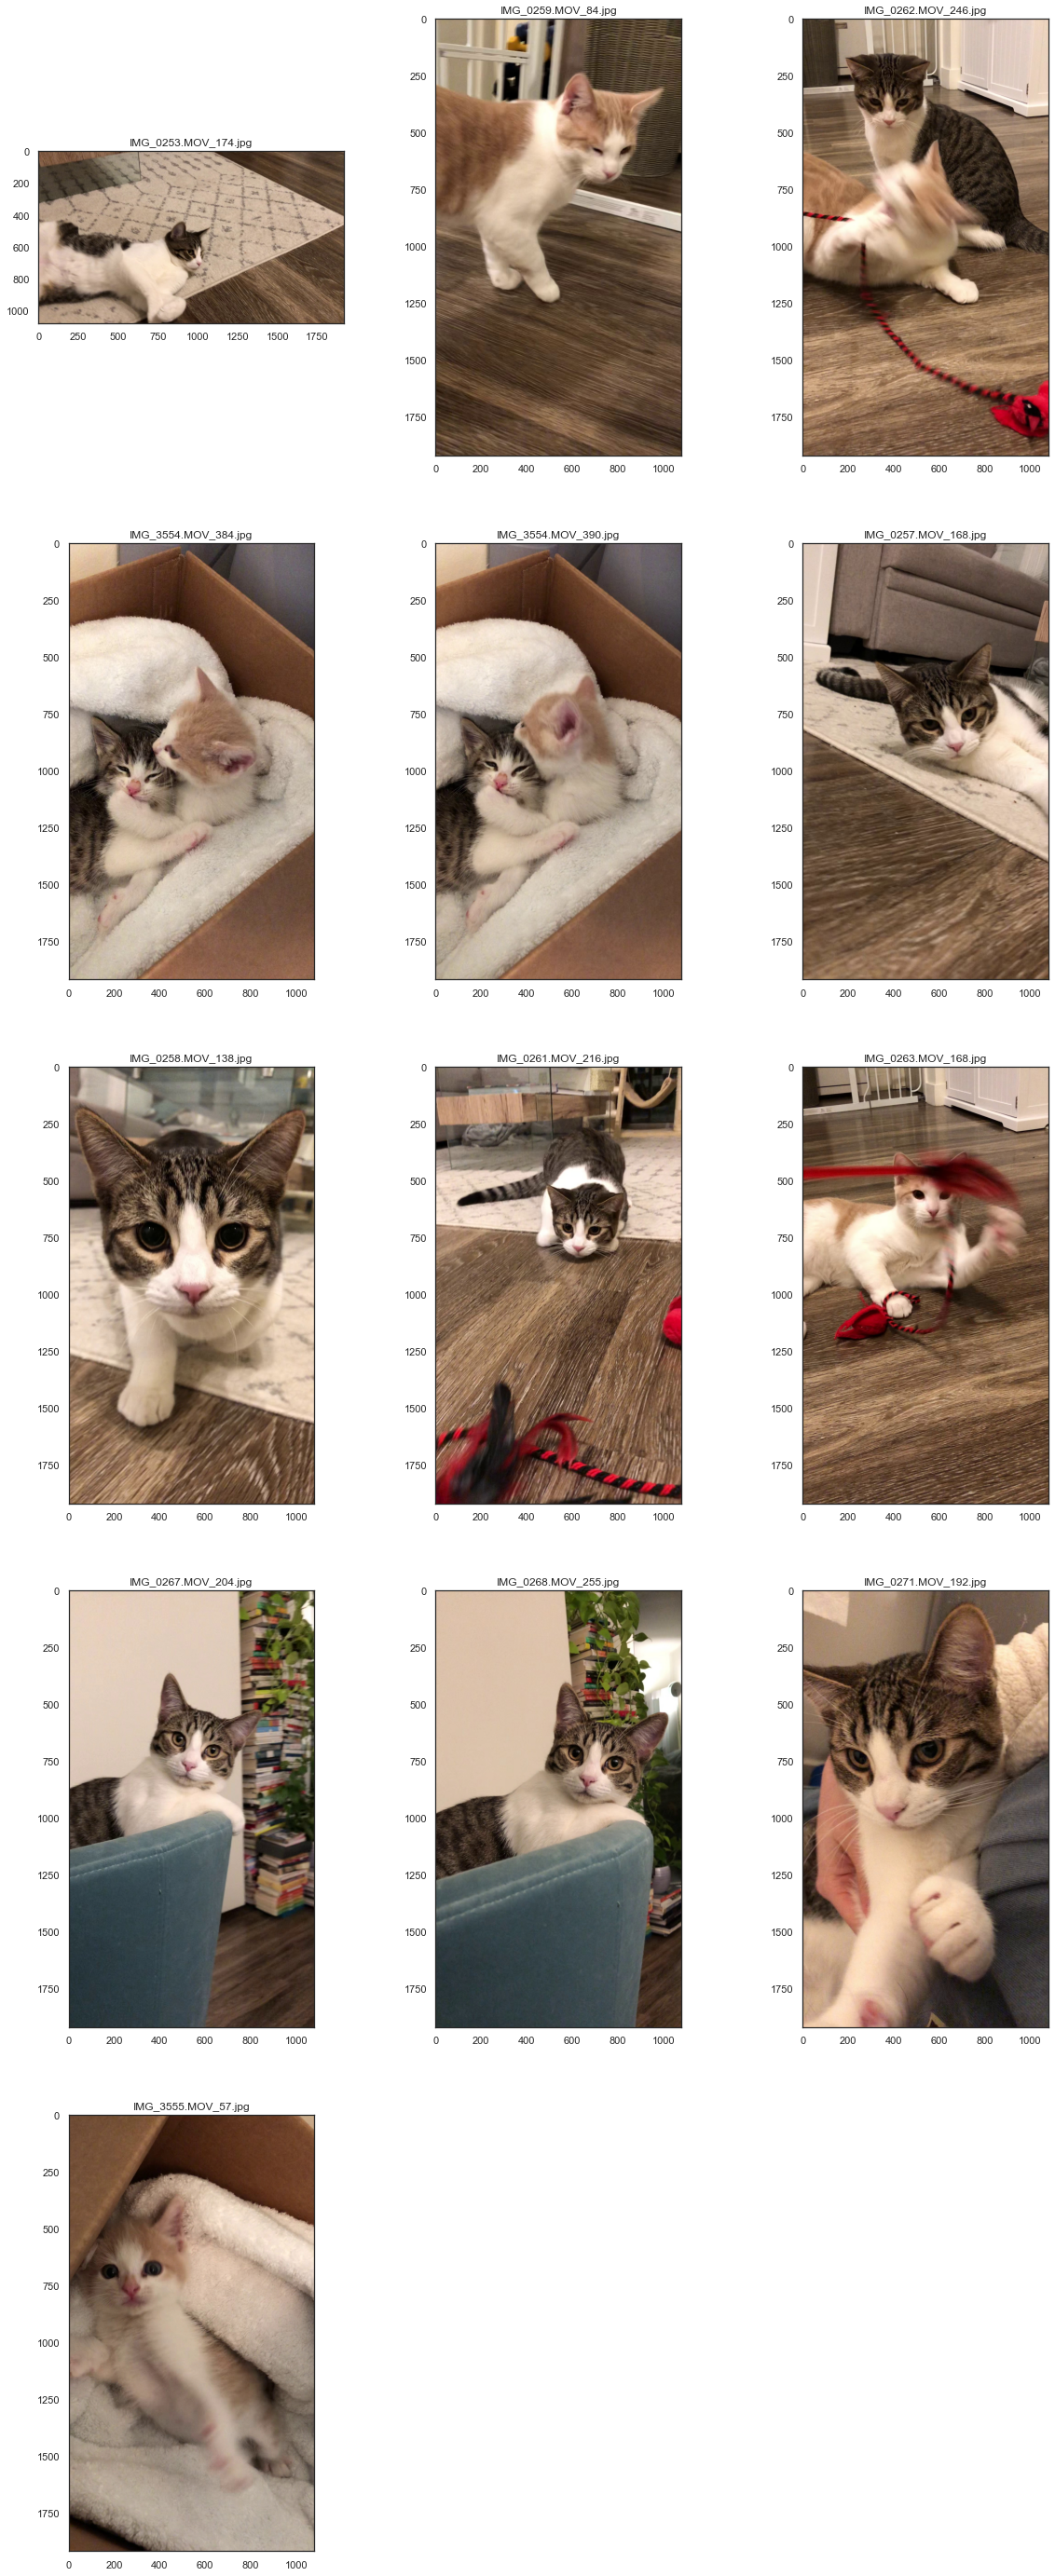

In [60]:
# randomforest

import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
# lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Prepare list of best frames
selected_img = results.filename.tolist()
test_len = len(results)

# Plots
subplot_row = test_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(selected_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

### Check false positive images

In [61]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

10

In [62]:
# False-positive: bad photos but predicted to be good
FP = results[(results.label==0)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

5

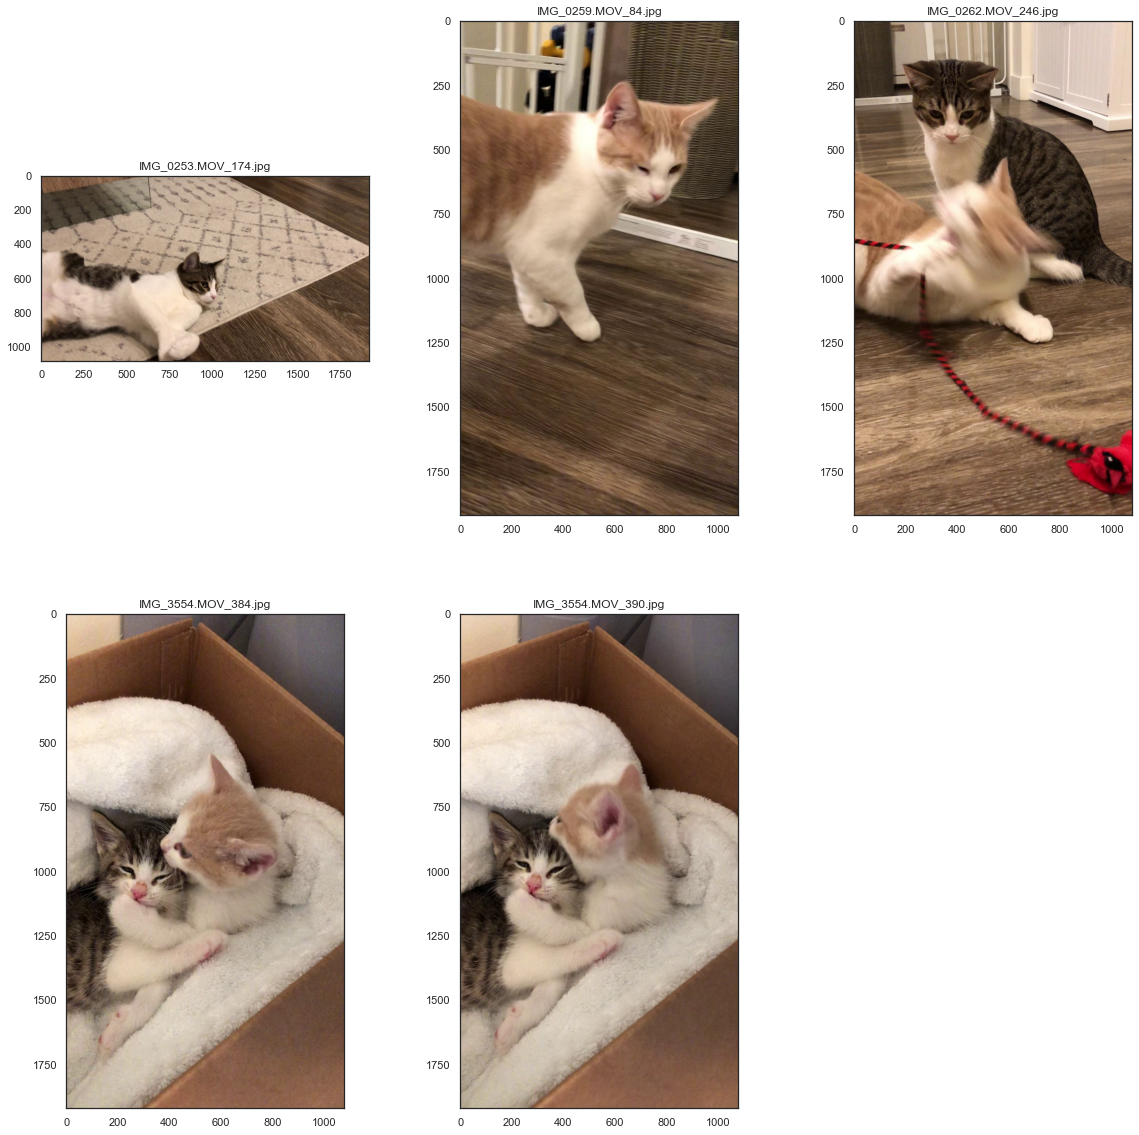

In [63]:
import cv2 as cv

# Plots
subplot_row = FP_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_all_1/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()